# Exploratory Data Analysis Cleaning and Flux Checks

**Goals**

1) Ensure data integrity
2) Remove missing or flagged data that may distort results

**Tasks**

1) Drop rows with NaN, NA, or zero-valued fluxes
2) Identify and quantify flux flags (e.g., saturation, deblending issues)
3) Pie chart: Ratio of clean vs flagged detections

In [132]:
# libraries, imports, etc
import numpy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

print('numpy version: ', numpy.__version__)
print('matplotlib version: ', matplotlib.__version__)

numpy version:  2.0.2
matplotlib version:  3.10.1


In [97]:
# TAP Service 
from lsst.rsp import get_tap_service, retrieve_query
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

service = get_tap_service("tap")
assert service is not None

In [98]:
# Selected Datasets

#1) DiaObject - core table for preprocessed time-varying object detections
diaobject_query = "SELECT column_name, datatype, description, unit "+\
                 "FROM TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.DiaObject'"
diaobject_results = service.search(diaobject_query)
diaobject_results_table = diaobject_results.to_table().to_pandas()
print('Number of columns available in the DiaObject catalog: ', len(diaobject_results_table))

#2) DiaSource - individual photometric measurements (light curves) of variables
diasource_query = "SELECT column_name, datatype, description, unit "+\
                 "FROM TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.DiaSource'"
diasource_results = service.search(diasource_query)
diasource_results_table = diasource_results.to_table().to_pandas()
print('Number of columns available in the DiaSource catalog: ', len(diasource_results_table))

#3) ForcedSource - uniform photometry across bands/images; color and P-L/P-L-C relations 
forcedsource_query = "SELECT column_name, datatype, description, unit "+\
                 "FROM TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.ForcedSource'"
forcedsource_results = service.search(forcedsource_query)
forcedsource_results_table = forcedsource_results.to_table().to_pandas()
print('Number of columns available in the ForcedSource catalog: ', len(forcedsource_results_table))

#4) Object - static properties; mean position, reference band, color, etc
object_query = "SELECT column_name, datatype, description, unit "+\
                 "FROM TAP_SCHEMA.columns "+\
                 "WHERE table_name = 'dp02_dc2_catalogs.Object'"
object_results = service.search(object_query)
object_results_table = object_results.to_table().to_pandas()
print('Number of columns available in the Object catalog: ', len(object_results_table))

Number of columns available in the DiaObject catalog:  138
Number of columns available in the DiaSource catalog:  67
Number of columns available in the ForcedSource catalog:  39
Number of columns available in the Object catalog:  991


In [99]:
# display table previews
diaobject_results_table

,column_name,datatype,description,unit
0,decl,double,Mean Declination of DIASources in the diaObject,deg
1,diaObjectId,long,Unique id.,
2,gPSFluxChi2,double,Chi^2 statistic for the scatter of gPSFlux aro...,
3,gPSFluxErrMean,double,Mean of the diaSource PSF flux uncertainties,
4,gPSFluxLinearIntercept,double,y-intercept of a linear model fit to diaSource...,
...,...,...,...,...
133,zPSFluxSkew,double,Skew of diaSource PSF flux,
134,zPSFluxStetsonJ,double,StetsonJ statistic of diaSource PSF flux,
135,zTOTFluxMean,double,Weighted mean of the PSF flux forced photomete...,
136,zTOTFluxMeanErr,double,Standard error on zTOTFluxMean,


In [100]:
diasource_results_table

,column_name,datatype,description,unit
0,apFlux,double,Flux within 12.0-pixel aperture,nJy
1,apFlux_flag,boolean,General Failure Flag,
2,apFlux_flag_apertureTruncated,boolean,Aperture did not fit within measurement image,
3,apFluxErr,double,Flux uncertainty within 12.0-pixel aperture,nJy
4,bboxSize,long,Bounding box of diaSource footprint,
...,...,...,...,...
62,totFluxErr,double,Forced PSF flux uncertainty measured on the di...,nJy
63,x,double,"Unweighted first moment centroid, overall cent...",pixel
64,xErr,float,1-sigma uncertainty on x position,pixel
65,y,double,"Unweighted first moment centroid, overall cent...",pixel


In [101]:
forcedsource_results_table

,column_name,datatype,description,unit
0,band,char,Abstract filter that is not associated with a ...,
1,ccdVisitId,long,Unique ID of visit and detector for which forc...,
2,coord_dec,double,Fiducial ICRS Declination of Object centroid u...,deg
3,coord_ra,double,Fiducial ICRS Right Ascension of Object centro...,deg
4,detect_isPatchInner,boolean,True if Object seed is in the inner region of ...,
5,detect_isPrimary,boolean,True if Object seed has no children and is in ...,
6,detect_isTractInner,boolean,True if Object seed is in the inner region of ...,
7,forcedSourceId,long,Unique ID of forced source. Primary Key.,
8,localBackground_instFlux,double,Background in annulus around source,count
9,localBackground_instFluxErr,double,1-sigma uncertainty on the background in an an...,count


In [102]:
object_results_table

,column_name,datatype,description,unit
0,coord_dec,double,Fiducial ICRS Declination of centroid used for...,deg
1,coord_ra,double,Fiducial ICRS Right Ascension of centroid used...,deg
2,deblend_nChild,int,Number of children this object has (defaults t...,
3,deblend_skipped,boolean,Deblender skipped this source,
4,detect_fromBlend,boolean,This source is deblended from a parent with mo...,
...,...,...,...,...
986,z_psfFlux_flag_apCorr,boolean,Set if unable to aperture correct base_PsfFlux...,
987,z_psfFlux_flag_edge,boolean,Object was too close to the edge of the image ...,
988,z_psfFlux_flag_noGoodPixels,boolean,Not enough non-rejected pixels in data to atte...,
989,z_psfFluxErr,double,Flux uncertainty derived from linear least-squ...,nJy


In [103]:
# Counts of observations in each dataset
# 1) DiaObject
diaobject_count_query = "SELECT COUNT(*) FROM dp02_dc2_catalogs.DiaObject"
diaobject_count_result = service.search(diaobject_count_query)
print("Number of observations in DiaObject: ", diaobject_count_result.to_table()[0][0])

# 2) DiaSource
diasource_count_query = "SELECT COUNT(*) FROM dp02_dc2_catalogs.DiaSource"
diasource_count_result = service.search(diasource_count_query)
print("Number of observations in DiaSource: ", diasource_count_result.to_table()[0][0])

# 3) ForcedSource
forcedsource_count_query = "SELECT COUNT(*) FROM dp02_dc2_catalogs.ForcedSource"
forcedsource_count_result = service.search(forcedsource_count_query)
print("Number of observations in ForcedSource: ", forcedsource_count_result.to_table()[0][0])

# 4) Object
object_count_query = "SELECT COUNT(*) FROM dp02_dc2_catalogs.Object"
object_count_result = service.search(object_count_query)
print("Number of observations in Object: ", object_count_result.to_table()[0][0])

Number of observations in DiaObject:  41301558
Number of observations in DiaSource:  162448407
Number of observations in ForcedSource:  111208556233
Number of observations in Object:  278318452


We need to use ADQL to filter and sample before downloading, then clean further in Python for EDA since loading hundreds of millions of rows (```ForcedSource``` having 111 billion alone would be impossible since pandas is not optimized for raw huge datasets and dropna() becomes impractical). 

In [104]:
# DiaObject sample (pre-processed detections)

# DiaObject g-band
diaobjectG_query = """
SELECT TOP 100000
    decl, diaObjectId, gPSFluxChi2, gPSFluxErrMean, gPSFluxLinearSlope,
    gPSFluxMAD, gPSFluxMax, gPSFluxMean, gPSFluxMeanErr, gPSFluxMin, gPSFluxNdata,
    gPSFluxSigma, gPSFluxStetsonJ
FROM dp02_dc2_catalogs.DiaObject
"""
diaobjectG_df = service.search(diaobjectG_query).to_table().to_pandas()

# DiaObject r-band
diaobjectR_query = """
SELECT TOP 100000
    decl, diaObjectId, rPSFluxChi2, rPSFluxErrMean, rPSFluxLinearSlope,
    rPSFluxMAD, rPSFluxMax, rPSFluxMean, rPSFluxMeanErr, rPSFluxMin, rPSFluxNData,
    rPSFluxSigma, rPSFluxStetsonJ
FROM dp02_dc2_catalogs.DiaObject
"""
diaobjectR_df = service.search(diaobjectR_query).to_table().to_pandas()

# DiaObject i-band
diaobjectI_query = """
SELECT TOP 100000
    decl, diaObjectId, iPSFluxChi2, iPSFluxErrMean, iPSFluxLinearSlope,
    iPSFluxMAD, iPSFluxMax, iPSFluxMean, iPSFluxMeanErr, iPSFluxMin, iPSFluxNData,
    iPSFluxSigma, iPSFluxStetsonJ
FROM dp02_dc2_catalogs.DiaObject
"""
diaobjectI_df = service.search(diaobjectI_query).to_table().to_pandas()

# DiaSource sample (time-domain photometry)
diasource_query = """
SELECT TOP 100000
    coord_dec, coord_ra, decl,
    diaObjectId, diaSourceId, filterName
    forced_PsfFlux_flag, forced_PsfFlux_flag_edge, 
    forced_PsfFlux_flag_noGoodPixels, midPointTai,
    psfFlux_flag, psfFlux_flag_edge, psfFlux_flag_noGoodPixels,
    psFlux, psFluxErr
FROM dp02_dc2_catalogs.DiaSource
"""
diasource_df = service.search(diasource_query).to_table().to_pandas()

# ForcedSource sample (cleaner/consistent photometry)
forcedsource_query = """
SELECT TOP 100000
    objectId, band, psfFlux, psfFluxErr
    psfFlux_flag, psfDiffFlux, psfDiffFluxErr
    psfDiffFlux_flag, coord_ra, coord_dec
FROM dp02_dc2_catalogs.ForcedSource
"""
forcedsource_df = service.search(forcedsource_query).to_table().to_pandas()

# Object sample (reference catalog)

# Object g-band
objectG_query = """
SELECT TOP 100000
    objectId, coord_ra, coord_dec, footprintArea, g_apFlux_flag, 
    g_apFlux_flag_apertureTruncated, g_bdChi2, g_bdFluxDErr, 
    g_calib_astrometry_used, g_calib_photometry_used, g_calibFlux_flag, 
    g_calibFlux_flag_apertureTruncated, g_cModel_flag, g_cModelFlux, g_decl, 
    g_extendedness, g_extendedness_flag, g_i_flag, g_inputCount, g_pixelFlags_bad, 
    g_psfFlux, g_psfFlux_flag, g_psfFluxErr, g_ra

FROM dp02_dc2_catalogs.Object
"""
objectG_df = service.search(objectG_query).to_table().to_pandas()

# Object r-band
objectR_query = """
SELECT TOP 100000
    objectId, coord_ra, coord_dec, footprintArea, r_apFlux_flag, 
    r_apFlux_flag_apertureTruncated, r_bdChi2, r_bdFluxDErr, 
    r_calib_astrometry_used, r_calib_photometry_used, r_calibFlux_flag, 
    r_calibFlux_flag_apertureTruncated, r_cModel_flag, r_cModelFlux, r_decl, 
    r_extendedness, r_extendedness_flag, r_i_flag, r_inputCount, r_pixelFlags_bad, 
    r_psfFlux, r_psfFlux_flag, r_psfFluxErr, r_ra

FROM dp02_dc2_catalogs.Object
"""
objectR_df = service.search(objectR_query).to_table().to_pandas()

# Object i-band 
objectI_query = """
SELECT TOP 100000
    objectId, coord_ra, coord_dec, footprintArea, i_apFlux_flag, 
    i_apFlux_flag_apertureTruncated, i_bdChi2, i_bdFluxDErr, 
    i_calib_astrometry_used, i_calib_photometry_used, i_calibFlux_flag, 
    i_calibFlux_flag_apertureTruncated, i_cModel_flag, i_cModelFlux, i_decl, 
    i_extendedness, i_extendedness_flag, i_i_flag, i_inputCount, i_pixelFlags_bad, 
    i_psfFlux, i_psfFlux_flag, i_psfFluxErr, i_ra

FROM dp02_dc2_catalogs.Object
"""
objectI_df = service.search(objectI_query).to_table().to_pandas()

In [105]:
# Creating csv files, run once!

# DiaObject (g, r, and i bands)
diaobjectG_df.to_csv("diaobjectG_sample_relevant.csv", index=False)
diaobjectR_df.to_csv("diaobjectR_sample_relevant.csv", index=False)
diaobjectI_df.to_csv("diaobjectI_sample_relevant.csv", index=False)

# DiaSource
diasource_df.to_csv("diasource_sample_relevant.csv", index=False)

# ForcedSource
forcedsource_df.to_csv("forcedsource_sample_relevant.csv", index=False)

# Object (g, r, and i bands)
objectG_df.to_csv("objectG_sample_relevant.csv", index=False)
objectR_df.to_csv("objectR_sample_relevant.csv", index=False)
objectI_df.to_csv("objectI_sample_relevant.csv", index=False)

In [150]:
# Dropping rows and saving as cleaned csvs

# DiaObject dataframes (g, r, and i bands) 
diaobjectGdf = pd.read_csv("diaobjectG_sample_relevant.csv").dropna()
diaobjectRdf = pd.read_csv("diaobjectR_sample_relevant.csv").dropna()
diaobjectIdf = pd.read_csv("diaobjectI_sample_relevant.csv").dropna()

# DiaSource dataframe 
diasourcedf = pd.read_csv("diasource_sample_relevant.csv").dropna()

# ForcedSource dataframe
forcedsourcedf = pd.read_csv("forcedsource_sample_relevant.csv").dropna()

# Object dataframes (g, r, and i bands)
objectGdf = pd.read_csv("objectG_sample_relevant.csv").dropna()
objectRdf = pd.read_csv("objectR_sample_relevant.csv").dropna()
objectIdf = pd.read_csv("objectI_sample_relevant.csv").dropna()

# Checks

# print(diaobjectGdf) print(diaobjectRdf) print(diaobjectIdf) 
# print(diasourcedf) print(forcedsourcedf) print(objectGdf) 
# print(objectRdf) print(objectIdf)

# print(diaobjectRdf.isna().sum())

decl                  0
diaObjectId           0
rPSFluxChi2           0
rPSFluxErrMean        0
rPSFluxLinearSlope    0
rPSFluxMAD            0
rPSFluxMax            0
rPSFluxMean           0
rPSFluxMeanErr        0
rPSFluxMin            0
rPSFluxNData          0
rPSFluxSigma          0
rPSFluxStetsonJ       0
dtype: int64


In [107]:
# Creating csv files, run once!

diaobjectGdf.to_csv("diaobjectG_sample_relevant_cleaned.csv", index = False)
diaobjectRdf.to_csv("diaobjectR_sample_relevant_cleaned.csv", index = False)
diaobjectIdf.to_csv("diaobjectI_sample_relevant_cleaned.csv", index = False)
diasourcedf.to_csv("diasource_sample_relevant_cleaned.csv", index = False)
forcedsourcedf.to_csv("forcedsource_sample_relevant_cleaned.csv", index = False)
objectGdf.to_csv("objectG_sample_relevant_cleaned.csv", index = False)
objectRdf.to_csv("objectR_sample_relevant_cleaned.csv", index = False)
objectIdf.to_csv("objectI_sample_relevant_cleaned.csv", index = False)

### Identifying flux flags

```DiaSource``` - psfFlux and psfFluxErr

```ForcedSource``` - psfFlux, psfFluxErr, psfDiffFlux, psfDiffFluxErr

```Object``` - cModelFlux, calibFlux 

In [108]:
print(forcedsourcedf.columns)
print(objectGdf.columns)
print(objectRdf.columns)
print(objectIdf.columns)

Index(['objectId', 'band', 'psfFlux', 'psfFlux_flag', 'psfDiffFlux',
       'psfDiffFlux_flag', 'coord_ra', 'coord_dec'],
      dtype='object')
Index(['objectId', 'coord_ra', 'coord_dec', 'footprintArea', 'g_apFlux_flag',
       'g_apFlux_flag_apertureTruncated', 'g_bdChi2', 'g_bdFluxDErr',
       'g_calib_astrometry_used', 'g_calib_photometry_used',
       'g_calibFlux_flag', 'g_calibFlux_flag_apertureTruncated',
       'g_cModel_flag', 'g_cModelFlux', 'g_decl', 'g_extendedness',
       'g_extendedness_flag', 'g_i_flag', 'g_inputCount', 'g_pixelFlags_bad',
       'g_psfFlux', 'g_psfFlux_flag', 'g_psfFluxErr', 'g_ra'],
      dtype='object')
Index(['objectId', 'coord_ra', 'coord_dec', 'footprintArea', 'r_apFlux_flag',
       'r_apFlux_flag_apertureTruncated', 'r_bdChi2', 'r_bdFluxDErr',
       'r_calib_astrometry_used', 'r_calib_photometry_used',
       'r_calibFlux_flag', 'r_calibFlux_flag_apertureTruncated',
       'r_cModel_flag', 'r_cModelFlux', 'r_decl', 'r_extendedness',
       'r

is_flagged
False    96966
True      3034
Name: count, dtype: int64


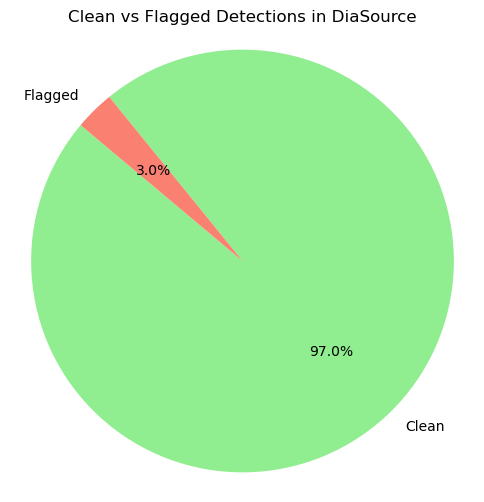

is_flagged
False    97006
True      2994
Name: count, dtype: int64


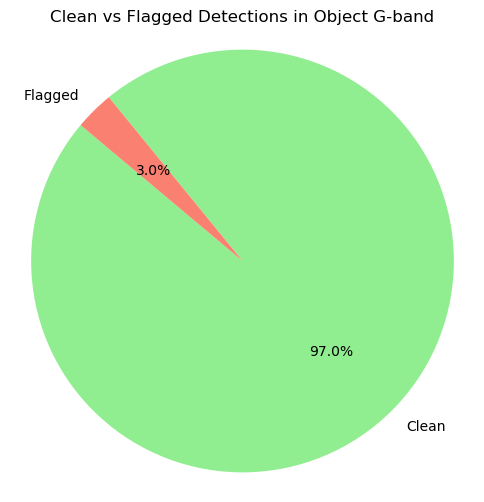

is_flagged
False    96873
True      3127
Name: count, dtype: int64


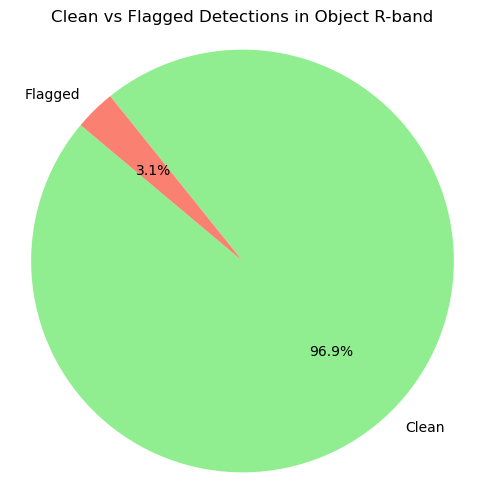

In [122]:
# Quantifying flux flags

# We dropped missing values, now filter out flag columns and zero checks for quality improvement

# DiaSource
diasourcedf = diasourcedf[
    (~diasourcedf['psfFlux_flag']) &
    (~diasourcedf['psfFlux_flag_edge']) &
    (~diasourcedf['psfFlux_flag_noGoodPixels']) &
    (diasourcedf['psFlux'] > 0)
]

# Object (g, r, i bands) 
objectGdf = objectGdf[
    (~objectGdf['g_psfFlux_flag']) &
    (objectGdf['g_psfFlux'] > 0)
]

objectRdf = objectRdf[
    (~objectRdf['r_psfFlux_flag']) &
    (objectRdf['r_psfFlux'] > 0)
]

objectIdf = objectIdf[
    (~objectIdf['i_psfFlux_flag']) &
    (objectIdf['i_psfFlux'] > 0)
]

# Pie Chart 

# Note: DiaObject and ForcedSource don't have booleans that behave as quality flags,
# both DiaObject and ForcedSource were skipped to avoid misclassification

# DiaSource 

diasourcedf_full = pd.read_csv("diasource_sample_relevant.csv")
# flag indicator column
diasourcedf_full['is_flagged'] = diasourcedf_full[
    ['psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels']
].astype(bool).any(axis=1)

diasourceflag_counts = diasourcedf_full['is_flagged'].value_counts()
print(diasourceflag_counts)

labels = ['Clean', 'Flagged']
sizes = [diasourceflag_counts[False], diasourceflag_counts[True]]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Clean vs Flagged Detections in DiaSource')
plt.axis('equal')  # circle
plt.show()

# Object G-band 
objectGdf_full = pd.read_csv("objectG_sample_relevant.csv")
# flag indicator column
objectGdf_full['is_flagged'] = objectGdf_full['g_psfFlux_flag'].fillna(False).astype(bool)

objectGflag_counts = objectGdf_full['is_flagged'].value_counts()
print(objectGflag_counts)

labels = ['Clean', 'Flagged']
sizes = [objectGflag_counts[False], objectGflag_counts[True]]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Clean vs Flagged Detections in Object G-band')
plt.axis('equal')  
plt.show()

# Object R-band 
objectRdf_full = pd.read_csv("objectR_sample_relevant.csv")
# flag indicator column
objectRdf_full['is_flagged'] = objectRdf_full['r_psfFlux_flag'].fillna(False).astype(bool)

objectRflag_counts = objectRdf_full['is_flagged'].value_counts()
print(objectRflag_counts)

labels = ['Clean', 'Flagged']
sizes = [objectRflag_counts[False], objectRflag_counts[True]]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Clean vs Flagged Detections in Object R-band')
plt.axis('equal')  
plt.show()

is_flagged
False    96868
True      3132
Name: count, dtype: int64


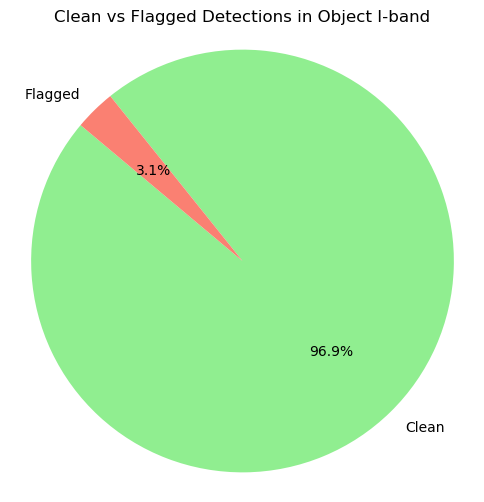

In [129]:
# Separating pie charts, Rubin Science Platform starts glitching when too much code is in one cell

# Object I-band 
objectIdf_full = pd.read_csv("objectI_sample_relevant.csv")
# flag indicator column
objectIdf_full['is_flagged'] = objectIdf_full['i_psfFlux_flag'].fillna(False).astype(bool)

objectIflag_counts = objectIdf_full['is_flagged'].value_counts()
print(objectIflag_counts)

labels = ['Clean', 'Flagged']
sizes = [objectIflag_counts[False], objectIflag_counts[True]]
colors = ['lightgreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Clean vs Flagged Detections in Object I-band')
plt.axis('equal')  
plt.show()

In [130]:
# Make csvs files, run once!

diasourcedf.to_csv("diasource_sample_relevant_flagcleaned.csv", index=False)
objectGdf.to_csv("objectG_sample_relevant_flagcleaned.csv", index=False)
objectRdf.to_csv("objectR_sample_relevant_flagcleaned.csv", index=False)
objectIdf.to_csv("objectI_sample_relevant_flagcleaned.csv", index=False)

**Band Comparison**

Variability and Color Analysis
1) ```gPSFluxSigma``` vs ```rPSFluxSigma``` - Compare blue vs red variability, helps separate RR Lyrae (high in g) from Cepheids (moderate in r)

In [131]:
# Merging all bands
diaobject_merged = diaobjectGdf[['diaObjectId', 'gPSFluxSigma', 'gPSFluxMean']].merge(
    diaobjectRdf[['diaObjectId', 'rPSFluxSigma', 'rPSFluxMean']], on='diaObjectId').merge(
    diaobjectIdf[['diaObjectId', 'iPSFluxSigma', 'iPSFluxMean']], on='diaObjectId')

diaobject_merged['g_r'] = diaobject_merged['gPSFluxMean'] - diaobject_merged['rPSFluxMean']
diaobject_merged['r_i'] = diaobject_merged['rPSFluxMean'] - diaobject_merged['iPSFluxMean']
diaobject_merged['g_i'] = diaobject_merged['gPSFluxMean'] - diaobject_merged['iPSFluxMean']

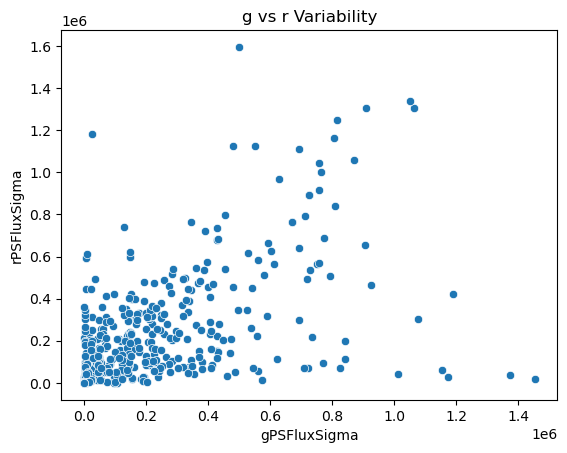

In [133]:
# gPSFluxSigma vs rPSFluxSigma

sns.scatterplot(data=diaobject_merged, x='gPSFluxSigma', y='rPSFluxSigma')
plt.xlabel('gPSFluxSigma'); plt.ylabel('rPSFluxSigma')
plt.title('g vs r Variability'); plt.show()

2) ```gPSFluxSigma vs iPSFluxSigma``` - Compare blue vs infrared variability, useful to isolate Miras (stronger variation in i) from RR Lyrae

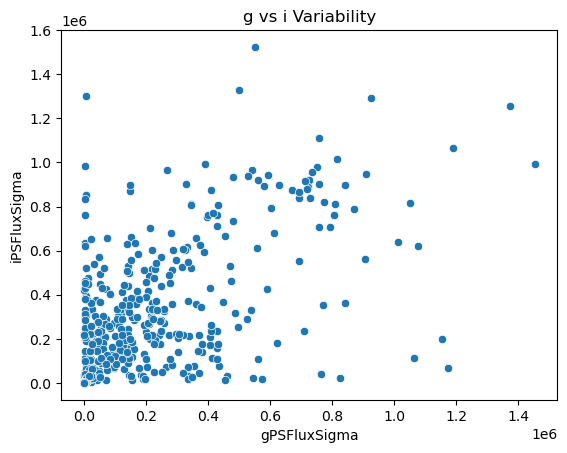

In [143]:
# gPSFluxSigma vs iPSFluxSigma

sns.scatterplot(data=diaobject_merged, x='gPSFluxSigma', y='iPSFluxSigma')
plt.xlabel('gPSFluxSigma'); plt.ylabel('iPSFluxSigma')
plt.title('g vs i Variability'); plt.show()

3) ```rPSFluxSigma``` vs ```iPSFluxSigma``` - Compare red vs redder variability, differentiates Cepheids (stronger in r) from Miras (stronger in i)

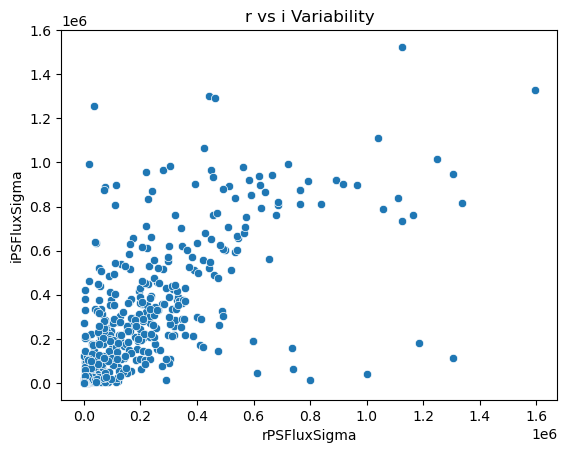

In [135]:
# rPSFluxSigma vs iPSFluxSigma
sns.scatterplot(data=diaobject_merged, x='rPSFluxSigma', y='iPSFluxSigma')
plt.xlabel('rPSFluxSigma'); plt.ylabel('iPSFluxSigma')
plt.title('r vs i Variability'); plt.show()

4) ```g - r``` vs ```gPSFluxSigma``` - Shows how blue-red color correlates with g-band variability, RR Lyrae are usually bluer, with higher variability

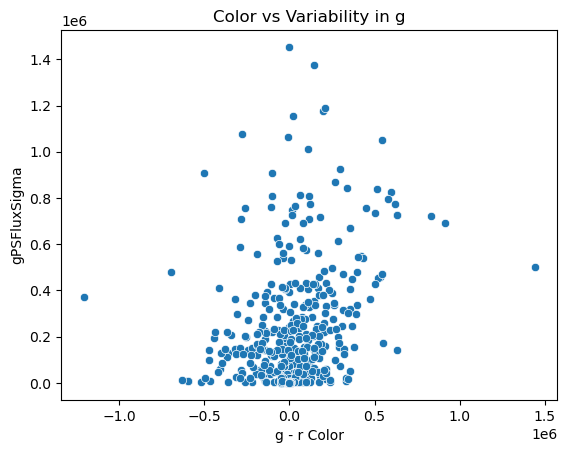

In [136]:
# g - r (x) vs gPSFluxSigma (y)
sns.scatterplot(data=diaobject_merged, x='g_r', y='gPSFluxSigma')
plt.xlabel('g - r Color'); plt.ylabel('gPSFluxSigma')
plt.title('Color vs Variability in g'); plt.show()

5) ```r - i vs iPSFluxSigma``` - Shows how red–infrared color tracks with i-band variability, great for flagging Miras, which are redder and vary more in i

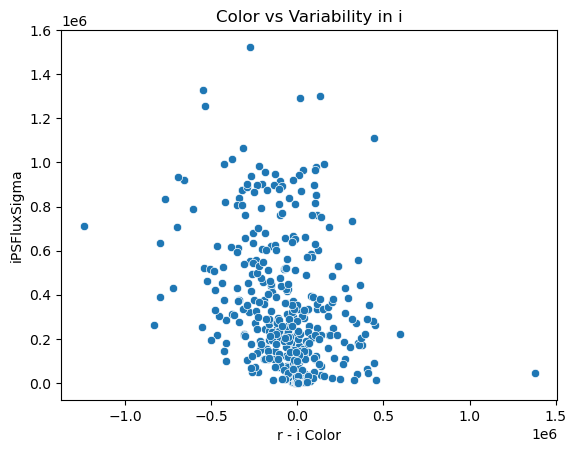

In [137]:
# r - i (x) vs iPSFluxSigma (y)
sns.scatterplot(data=diaobject_merged, x='r_i', y='iPSFluxSigma')
plt.xlabel('r - i Color'); plt.ylabel('iPSFluxSigma')
plt.title('Color vs Variability in i'); plt.show()

6) ```g - i``` vs ```rPSFluxSigma``` (the most informative band of all three) - Long baseline color, useful for separating cool vs hot variables, can highlight outliers or transition stars

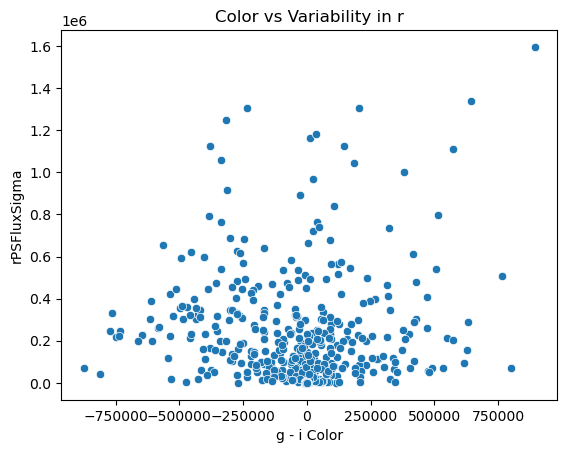

In [145]:
# g - i (x) vs rPSFluxSigma
sns.scatterplot(data=diaobject_merged, x='g_i', y='rPSFluxSigma')
plt.xlabel('g - i Color'); plt.ylabel('rPSFluxSigma')
plt.title('Color vs Variability in r'); plt.show()

7) Histograms of ```PSFluxSigma``` in Each Band - Helps visualize overall variability strength distribution by band

One histogram for each of:

a) ```gPSFluxSigma``` (std dev) vs number of star/detections (count)
b) ```rPSFluxSigma``` (std dev) vs number of star/detections (count)
c) ```iPSFluxSigma``` (std dev) vs number of star/detections (count)

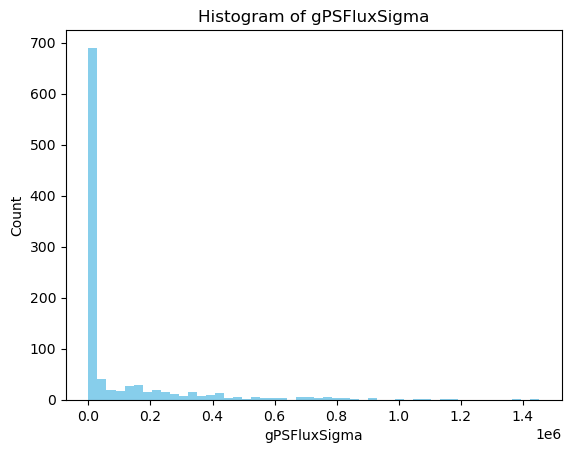

In [140]:
# gpsFluxSigma vs count
plt.hist(diaobject_merged['gPSFluxSigma'], bins=50, color='skyblue')
plt.title('Histogram of gPSFluxSigma'); plt.xlabel('gPSFluxSigma'); plt.ylabel('Count')
plt.show()

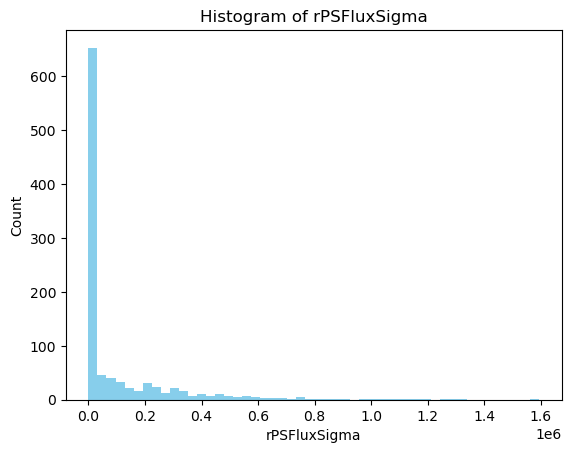

In [141]:
# rpsFluxSigma vs count
plt.hist(diaobject_merged['rPSFluxSigma'], bins=50, color='skyblue')
plt.title('Histogram of rPSFluxSigma'); plt.xlabel('rPSFluxSigma'); plt.ylabel('Count')
plt.show()

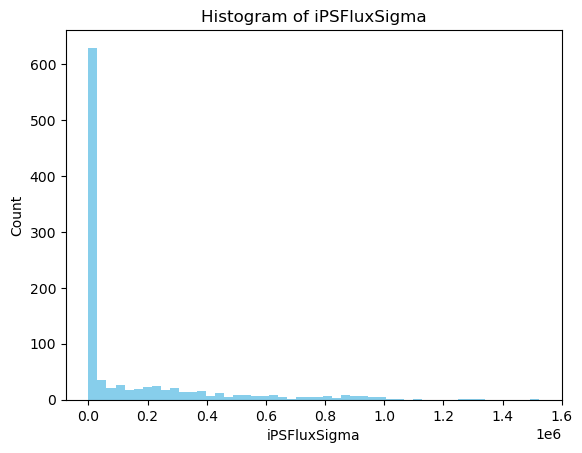

In [142]:
# ipsFluxSigma vs count
plt.hist(diaobject_merged['iPSFluxSigma'], bins=50, color='skyblue')
plt.title('Histogram of iPSFluxSigma'); plt.xlabel('iPSFluxSigma'); plt.ylabel('Count')
plt.show()

**Outlier Validation**

High variability metrics don’t always mean true variability. We:
1) Select stars with high Chi², MAD, Stetson J
2) Validate light curves for anomalies or bad data

**Findings**

1) ```gPSFluxSigma``` vs ```rPSFluxSigma```/```iPSFluxSigma``` shows how variability compares across bands. RR Lyrae vary more in g-band, so looking for points above the diagonal line when its plotted.
2) Cepheids and Miras often vary in more redder bands (r or i) below the diagonal. These plots can separate variable types based on where they fall relative to y = x. (roughly the diagonal line).
3) ```rPSFluxSigma``` vs ```iPSFluxSigma``` compares r and i band variability, showing that Cepheids tend to have higher varibility in R than i. Miras tend to vary more in than in r which can be used to distinguish Miras from Cepheids.
4) ```Color``` vs ```FluxSigma``` variables show that RR Lyrae are bluer (small or negative g - r, r - i) and show high variability in g, plots can isolate blue high variability objects which are likely RR Lyrae. Mira variables are very red and vary strongly in i, so if you see a cluster of high iPSFluxSigma at large r - i, they are likely Miras. Any in between these 2 stark contrasts are more likely to be Cepheids. 
5) Scattered high-variability sources in redder areas have the chance of being misclassified or transition stars, something to note going forward.
6) The histograms of all ```psFluxSigma``` variables vs ```count``` yield a majority of low variability in all 3 bands with a long tail of highly variable ones. Variable stars are the outliers on the right tail, which helps set up an idea of what the threshold could be for what counts as "variable". 

**Summary**

Most objects are mostly not variable but a subset shows strong variability in one or more bands. Color-variability trends help distinguish types. 

RR Lyrae = blue colors (g - r < 0) + high g-band capability

Cepheids = intermediate colors + moderate variability, stronger in r-band

Miras = very red (r - i > 0.5) + strong i-band variability

Cross-band variability comparison let you identify likely variable types and flag outliers or transitions.

**Results**

Pulsating stars behave differently across photometric bands:
1) RR Lyrae: Peak in blue/green band, short period, low metallacity, strong variation in blue bands, [g]
2) Cepheids: peak in visible red bands, intermediate period, good balance of amplitude/stability, [r]
3) Miras: Peak in infrared bands, long period, cool red giants, larger amplitudes in redder bands, [i]